In [5]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from ccs.files import ccs_reporter_dir


/scratch/users/ebronstein/conda/envs/eleuther-ccs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def load_experiment_results(paths):
    """
    Load experiment results from given paths in the ccs_reporters_dir.
    Can handle paths to both individual experiment directories and sweep directories.

    Args:
    paths (list of str): Relative paths in the ccs_reporters_dir.

    Returns:
    pd.DataFrame: DataFrame with the experiment results.
    """
    root_dir = ccs_reporter_dir().as_posix()
    all_data = []

    for path in paths:
        full_path = os.path.join(root_dir, path)

        for dirpath, dirnames, filenames in os.walk(full_path):
            # TODO: skipping transfer results for now.
            if "transfer" in dirpath:
                continue
            if "eval.csv" in filenames:
                # Extract model and dataset from the path
                parts = dirpath.replace(root_dir, '').strip('/').split('/')
                dataset = parts[-1]
                if len(parts) == 4:
                    model = parts[-2]
                elif len(parts) == 5:
                    model = os.path.join(*parts[-3:-1])
                else:
                    raise ValueError(f"Unexpected path: {dirpath}")
                # print(f"Loading {model} on {dataset}")

                # Load eval.csv
                eval_df = pd.read_csv(os.path.join(dirpath, "eval.csv"))
                eval_df.columns = ['eval_' + col for col in eval_df.columns]

                # Load lr_eval.csv
                lr_eval_df = pd.read_csv(os.path.join(dirpath, "lr_eval.csv"))
                lr_eval_df.columns = ['lr_eval_' + col for col in lr_eval_df.columns]

                # Load lm_eval.csv if exists
                lm_eval_file = os.path.join(dirpath, "lm_eval.csv")
                if os.path.exists(lm_eval_file):
                    lm_eval_df = pd.read_csv(lm_eval_file)
                    lm_eval_df.columns = ['lm_eval_' + col for col in lm_eval_df.columns]
                else:
                    lm_eval_df = pd.DataFrame(columns=['lm_eval_' + col for col in eval_df.columns])
                    lm_eval_df.loc[0] = [pd.NA] * len(lm_eval_df.columns)

                # Combine all dataframes
                combined_df = pd.concat([eval_df, lr_eval_df, lm_eval_df], axis=1)
                combined_df['model'] = model
                combined_df['dataset'] = dataset
                combined_df['path'] = dirpath.replace(root_dir, '').strip('/')

                all_data.append(combined_df)

    return pd.concat(all_data, ignore_index=True)


In [7]:
paths = [
    "sweeps/fervent-heisenberg",
    "sweeps/thirsty-wing",
    "sweeps/gallant-davinci",
]
results_df = load_experiment_results(paths)


In [8]:
def plot_accuracy_by_model(df):
    """
    Creates a figure with subplots for each model showing grouped bar plots
    of the average accuracy of CCS, LR, and Zero-Shot for each dataset.

    Args:
    df (pd.DataFrame): DataFrame with experiment results.
    """
    # Filter relevant columns
    df = df[
        [
            "model",
            "dataset",
            "eval_cal_acc_estimate",
            "lr_eval_cal_acc_estimate",
            "lm_eval_cal_acc_estimate",
        ]
    ]

    # Group by model and dataset and calculate mean
    grouped_df = df.groupby(["model", "dataset"]).mean().reset_index()

    # Find unique models
    models = grouped_df["model"].unique()

    # Set latex style for plots
    # plt.style.use("seaborn-paper")
    plt.style.use("seaborn-v0_8-poster")
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")

    # Create subplots
    fig, axes = plt.subplots(
        len(models), 1, figsize=(10, 5 * len(models)), sharex=True
    )

    if len(models) == 1:
        axes = [axes]  # Ensure axes is always a list

    for ax, model in zip(axes, models):
        # Filter data for this model
        model_df = grouped_df[grouped_df["model"] == model]

        # Plot grouped bar plot
        sns.barplot(
            data=model_df,
            x="dataset",
            y="eval_cal_acc_estimate",
            color="blue",
            ax=ax,
            label="CCS",
        )
        sns.barplot(
            data=model_df,
            x="dataset",
            y="lr_eval_cal_acc_estimate",
            color="orange",
            ax=ax,
            label="LR",
        )
        sns.barplot(
            data=model_df,
            x="dataset",
            y="lm_eval_cal_acc_estimate",
            color="green",
            ax=ax,
            label="Zero-Shot",
        )

        ax.set_title(f"Model: {model}")
        ax.set_ylabel("Average Accuracy")
        ax.set_xlabel("")

    # Add legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()


In [9]:
def plot_grouped_accuracy_by_model_with_labels(
    df,
    layer=None,
    ensembling=None,
    calibrated: bool = True,
):
    """
    Creates a figure with subplots for each model showing grouped bar plots
    of the average accuracy of CCS, LR, and Zero-Shot for each dataset, with accuracy labels on top of each bar.

    Args:
    df (pd.DataFrame): DataFrame with experiment results.
    """
    # Get columns names based on whether calibrated or not.
    if calibrated:
        acc_cols = [
            "eval_cal_acc_estimate",
            "lr_eval_cal_acc_estimate",
            "lm_eval_cal_acc_estimate",
        ]
    else:
        acc_cols = [
            "eval_acc_estimate",
            "lr_eval_acc_estimate",
            "lm_eval_acc_estimate",
        ]
    # Filter relevant columns
    df = df[
        [
            "model",
            "dataset",
            *acc_cols,
            "eval_layer",
            "lr_eval_layer",
            "lm_eval_layer",
            "eval_ensembling",
            "lr_eval_ensembling",
            "lm_eval_ensembling",
        ]
    ]

    # If layer is specified, filter by layer
    if layer is not None:
        df = df[
            (df["eval_layer"] == layer)
            & (df["lr_eval_layer"] == layer)
            & (df["lm_eval_layer"] == layer)
        ]
    # If ensembling is specified, filter by ensembling
    if ensembling is not None:
        df = df[
            (df["eval_ensembling"] == ensembling)
            & (df["lr_eval_ensembling"] == ensembling)
            & (
                (df["lm_eval_ensembling"] == ensembling)
                | df["lm_eval_ensembling"].isna()
            )
        ]
    # Group by model and dataset, and take the max accuracy
    grouped_df = df.groupby(["model", "dataset"]).max().reset_index()

    # Find unique models
    models = grouped_df["model"].unique()

    # Set seaborn style for plots
    plt.style.use("seaborn-v0_8-paper")

    # Create subplots
    fig, axes = plt.subplots(
        len(models), 1, figsize=(10, 5 * len(models)), sharex=True
    )

    if len(models) == 1:
        axes = [axes]  # Ensure axes is always a list

    # Create a color palette
    palette = ["blue", "orange", "green"]

    for ax, model in zip(axes, models):
        # Filter data for this model
        model_df = grouped_df[grouped_df["model"] == model]

        # Melt the DataFrame for easy plotting
        melted_df = model_df.melt(
            id_vars=["model", "dataset"],
            value_vars=acc_cols,
            var_name="method",
            value_name="accuracy",
        )

        # Map methods to more readable names
        method_mapping = {
            "eval_cal_acc_estimate"
            if calibrated
            else "eval_acc_estimate": "CCS",
            "lr_eval_cal_acc_estimate"
            if calibrated
            else "lr_eval_acc_estimate": "LR",
            "lm_eval_cal_acc_estimate"
            if calibrated
            else "lm_eval_acc_estimate": "Zero-Shot",
        }
        melted_df["method"] = melted_df["method"].map(method_mapping)

        # Plot grouped bar plot
        bars = sns.barplot(
            data=melted_df,
            x="dataset",
            y="accuracy",
            hue="method",
            palette=palette,
            ax=ax,
        )

        # Add text labels on top of each bar
        for bar in bars.patches:
            bars.annotate(
                format(bar.get_height(), ".2f"),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha="center",
                va="center",
                size=9,
                xytext=(0, 8),
                textcoords="offset points",
            )

        ax.set_title(f"Model: {model}")
        ax.set_ylabel("Average Accuracy")
        ax.set_xlabel("")

    # Add legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()


Ensembling: none, Calibrated: True


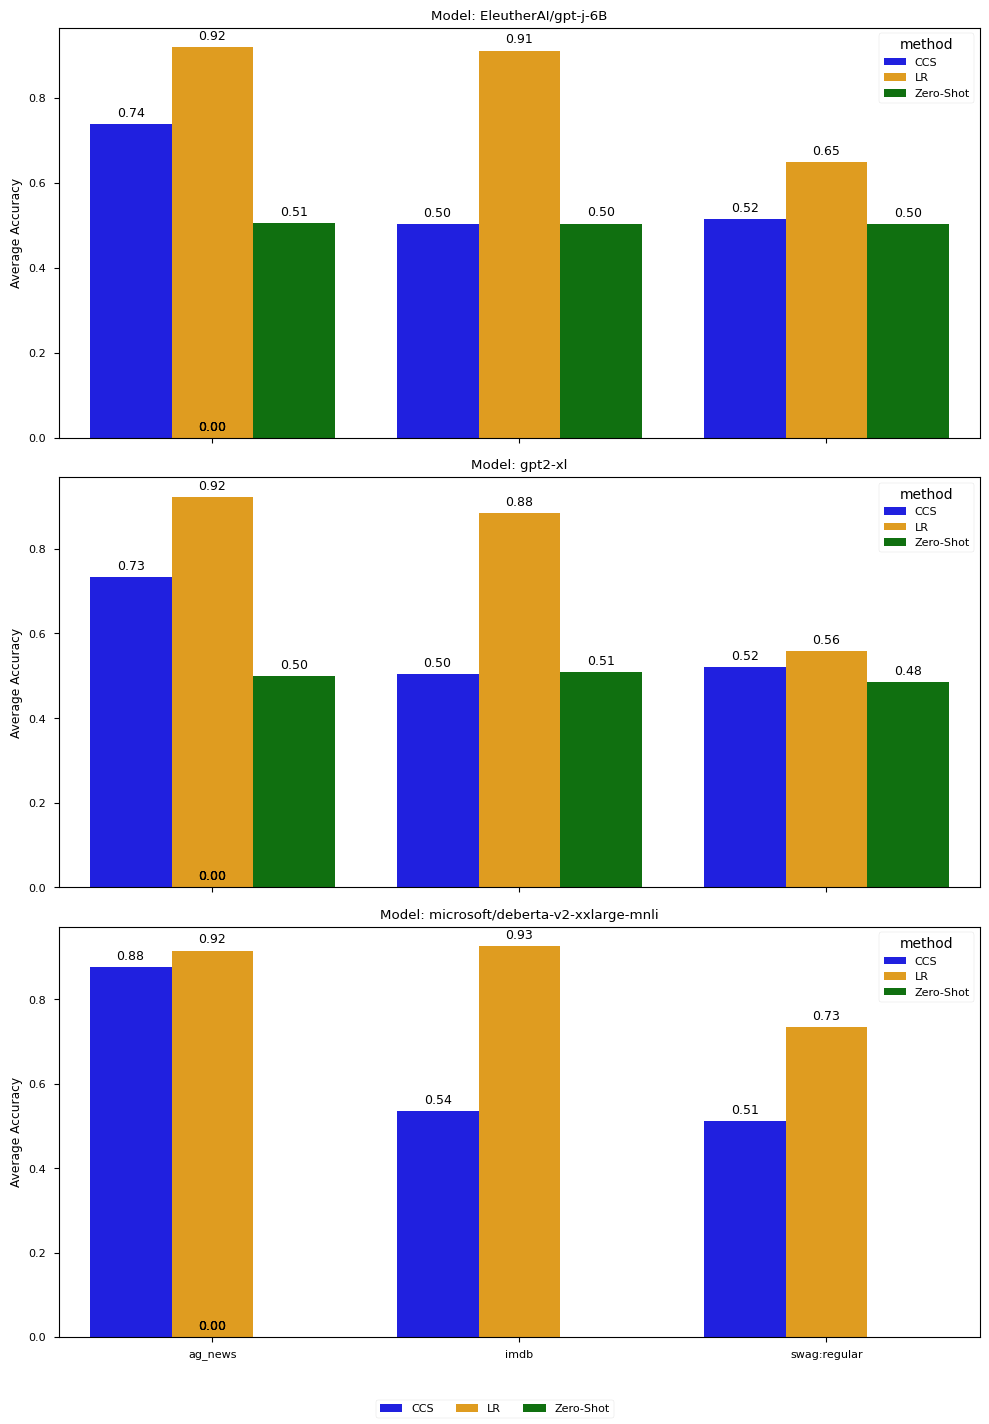

Ensembling: none, Calibrated: False


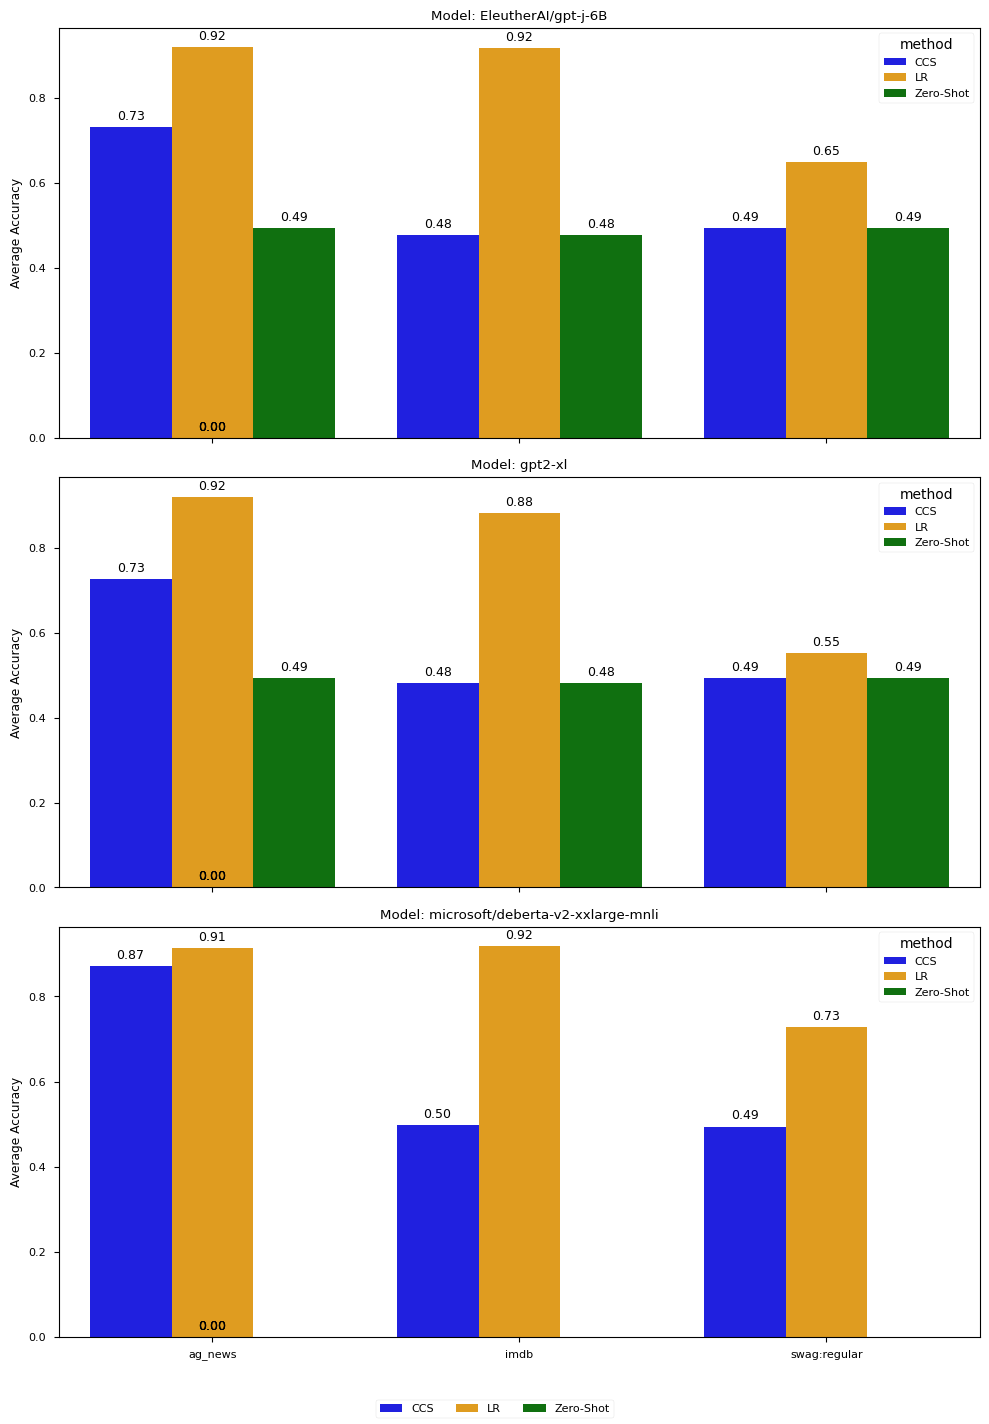

Ensembling: partial, Calibrated: True


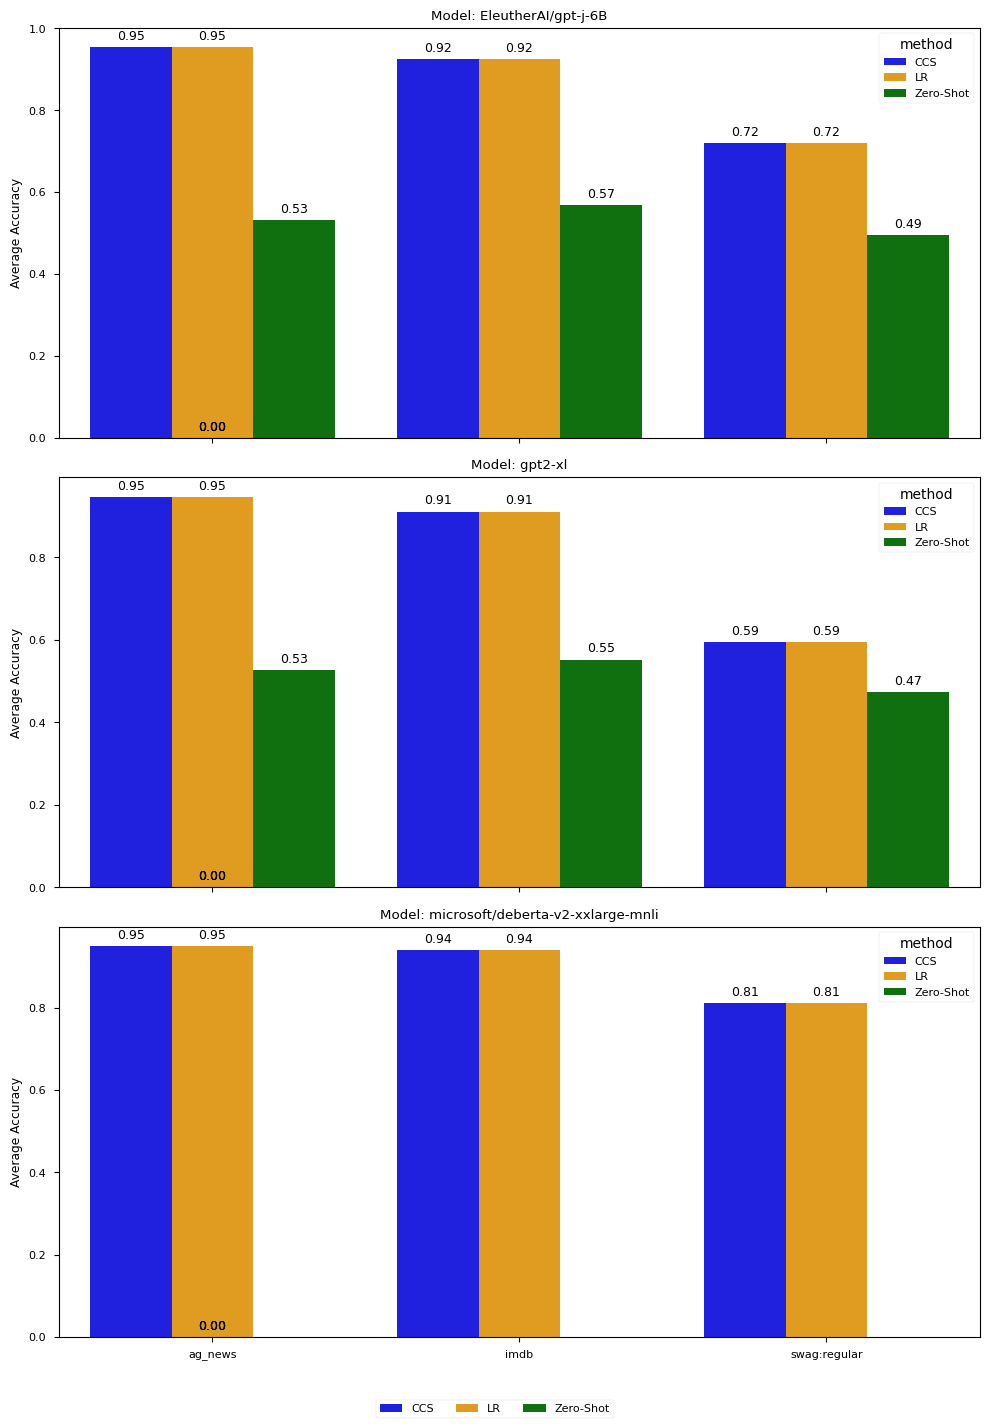

Ensembling: partial, Calibrated: False


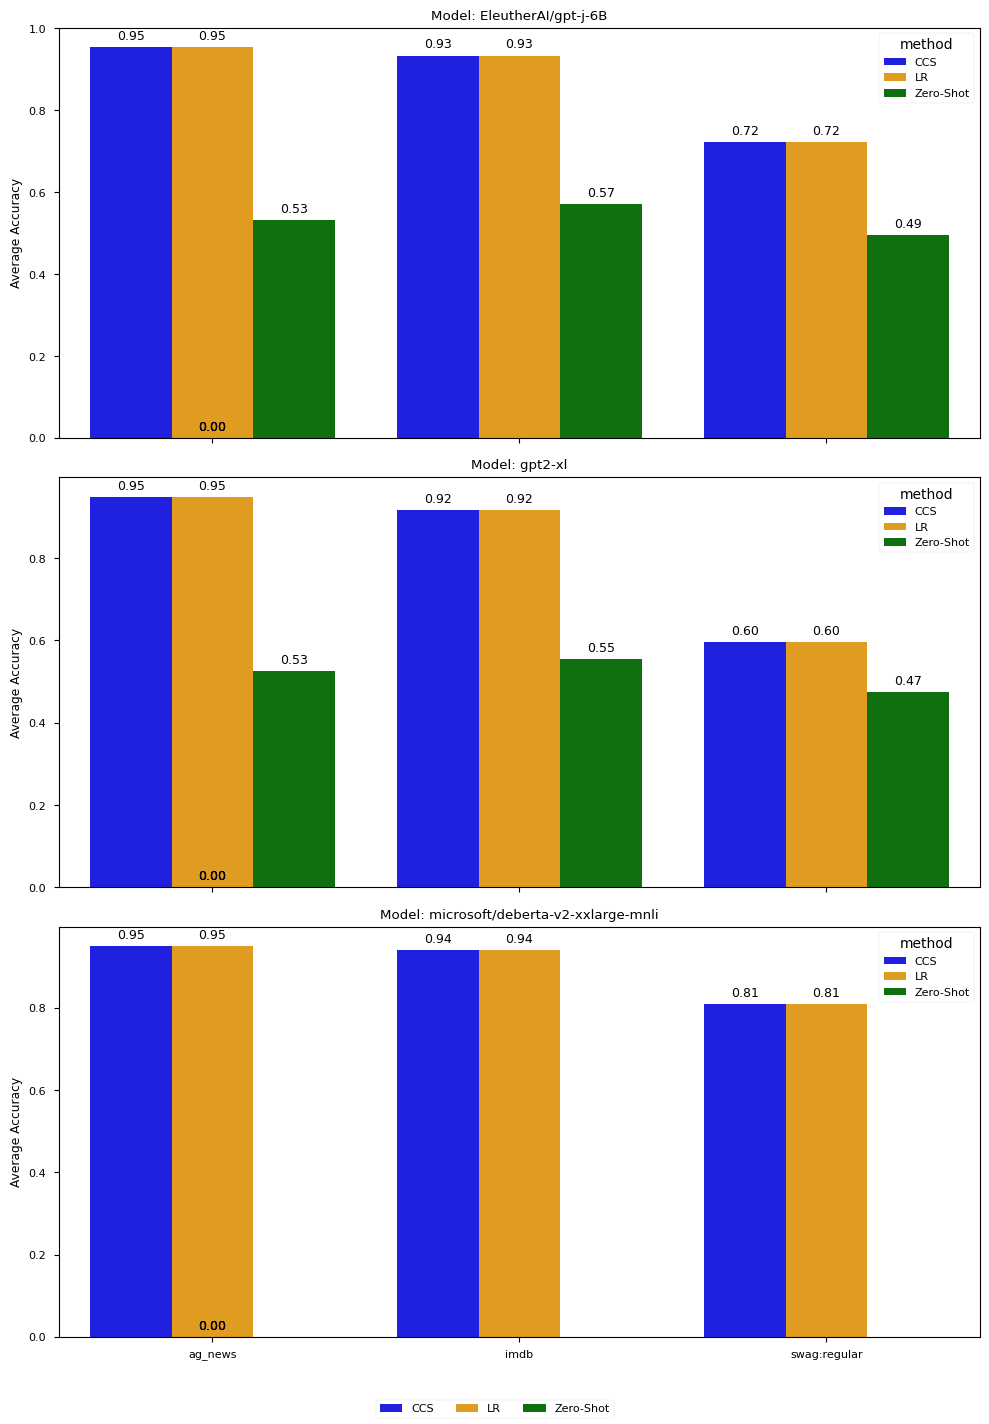

Ensembling: full, Calibrated: True


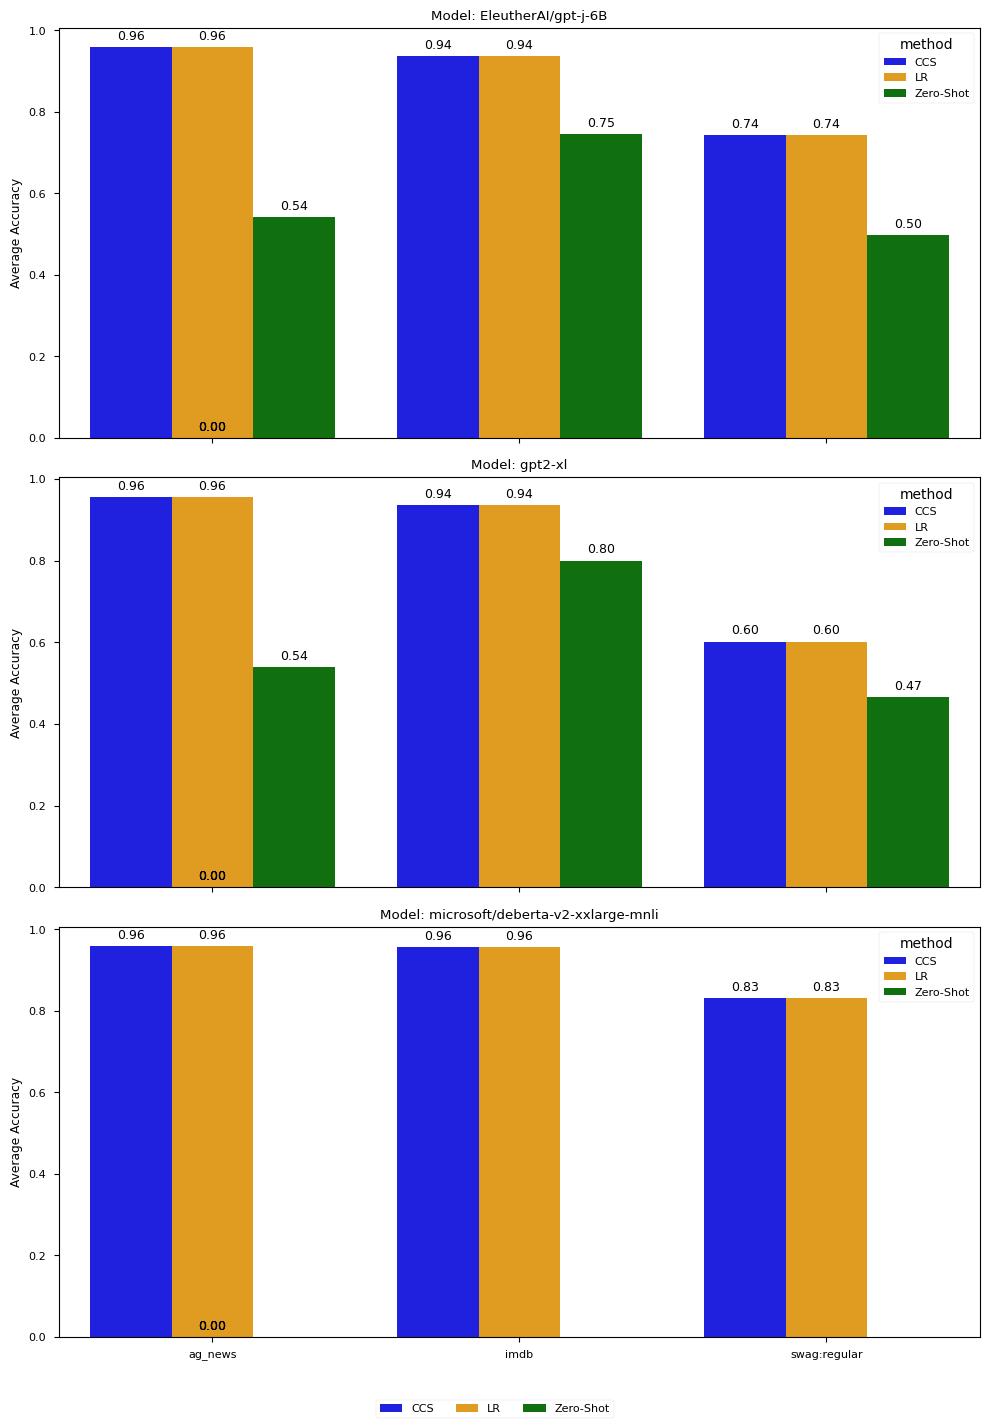

Ensembling: full, Calibrated: False


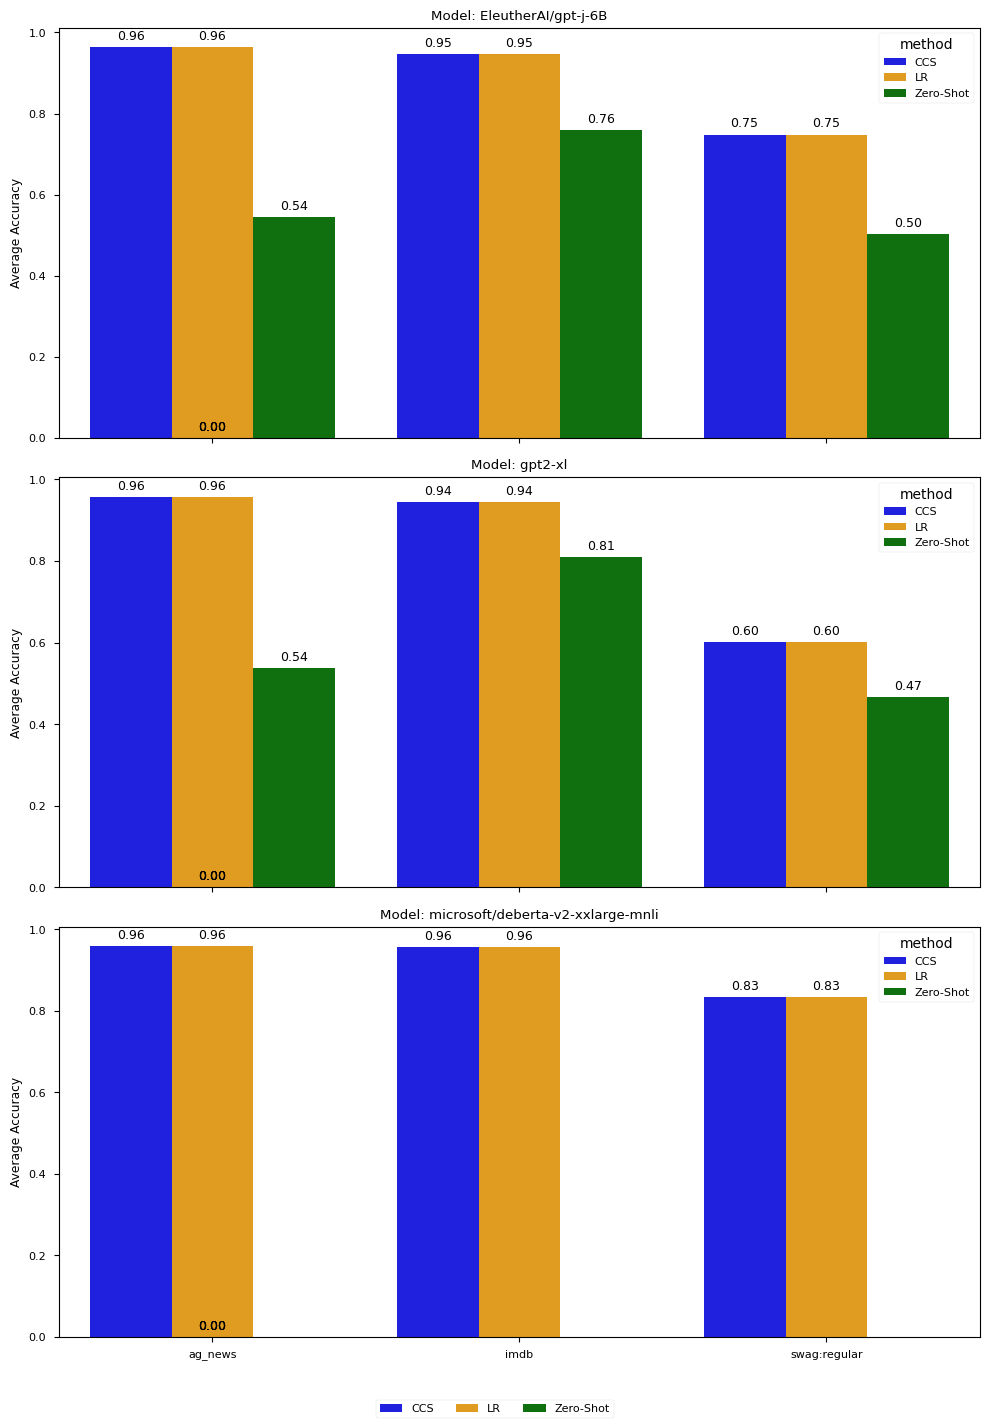

In [10]:
for ensembling in ["none", "partial", "full"]:
    for calibrated in [True, False]:
        print(f"Ensembling: {ensembling}, Calibrated: {calibrated}")
        plot_grouped_accuracy_by_model_with_labels(
            results_df, layer=None, ensembling=ensembling, calibrated=calibrated
        )
